In [2]:
import sys
import logging

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


In [3]:
from cstrees import csi_relation

ci = csi_relation.CI({1,2}, {3,4},{5})
print(ci)
dec = csi_relation.decomposition(ci)
for d in dec:
    print(d)

X1, X2 ⊥ X3, X4 | X5
X1 ⊥ X3 | X5
X1 ⊥ X4 | X5
X2 ⊥ X3 | X5
X2 ⊥ X4 | X5


In [182]:
wk = csi_relation.weak_union(ci)
for w in wk:
    print(w)

X1, X2 ⊥ X4 | X3, X5
X1, X2 ⊥ X3 | X4, X5
X2 ⊥ X3, X4 | X1, X5
X1 ⊥ X3, X4 | X2, X5


In [183]:
print("Original CI: ", ci)
pw = csi_relation.pairwise_cis(ci)
print("Pairwise CIs:")
for x in pw:
    print(x)

Original CI:  X1, X2 ⊥ X3, X4 | X5
Pairwise CIs:
X1 ⊥ X3 | X2, X4, X5
X1 ⊥ X4 | X2, X3, X5
X2 ⊥ X3 | X1, X4, X5
X2 ⊥ X4 | X1, X3, X5


In [184]:
c = csi_relation.Context({6:0})
csi = csi_relation.CSI(ci, c)

print("Original CSI: ", csi)
pw = csi_relation.pairwise_csis(csi)
print("Pairwise CSIs:")
for x in pw:
    print(x)

Original CSI:  X1, X2 ⊥ X3, X4 | X5, X6=0
Pairwise CSIs:
X1 ⊥ X3 | X2, X4, X5, X6=0
X1 ⊥ X4 | X2, X3, X5, X6=0
X2 ⊥ X3 | X1, X4, X5, X6=0
X2 ⊥ X4 | X1, X3, X5, X6=0


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


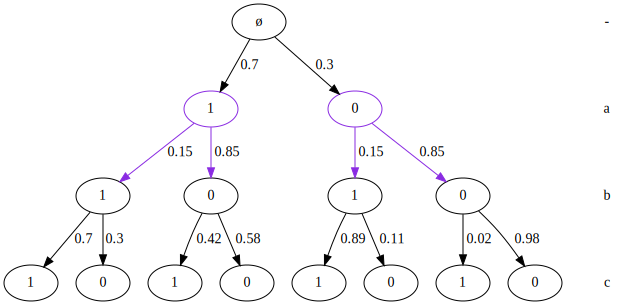

In [396]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [397]:

order = ["a", "b", "c"]
# Should order be expressed as the labels or as the levels?
# labels seems more natural but may include strings then which is a bit ugly.

# This is the order of the data columns.
s1 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s1)


score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707


In [398]:
#order = [0, 2, 1]
order = ["a", "c", "b"]  # We know that b should not be to the very right.
s2 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s2)


score at level 0 : -3116.1202505997753
score at level 1 : -3292.9646008758737
score at level 2 : -2123.9068190918438
-8532.991670567493


optimal order: ['b', 'a', 'c'], score -8222.118920345132
stages :{0: [<cstrees.stage.Stage object at 0x7febb944ac20>], 1: [<cstrees.stage.Stage object at 0x7febb94488e0>, <cstrees.stage.Stage object at 0x7febb9449f60>], 2: [], -1: [<cstrees.stage.Stage object at 0x7febbaa30e80>]}

Optimal CStree stagings per level:
level 0:
[]
level 1:
[0]
[1]
level 2:


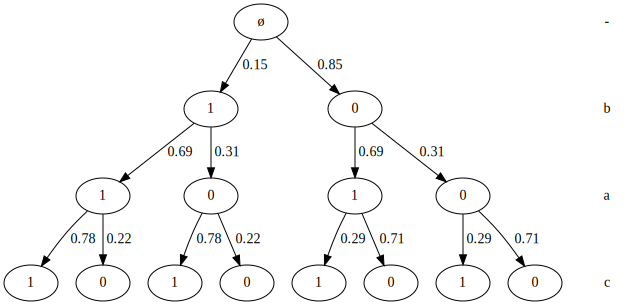

In [399]:
optord, score = ctl._find_optimal_order(
    x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [189]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')


In [190]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()


,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-


In [400]:
order = ["a", "b", "c"]
orderscore = sc.score_order(order, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
nodescores = [sc._score_order_at_level(order, level, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu") for level in range(len(order))]
print(orderscore)
print(nodescores)
print(np.sum(nodescores))
neig = ctl.get_relocation_neighborhood(order, 1, orderscore, nodescores, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(order)
print("nodescores: ", nodescores)

print("neig: ", list(neig))


score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707
[-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
-8273.345488222707
['a', 'b', 'c']
nodescores:  [-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
neig:  [0.4999999999999138, 0.4999999999999138, 8.631092375820474e-114]


In [456]:
orders, scores = ctl.gibbs_order_sampler(100000, x, max_cvars=2, alpha_tot=1.0, method="BDeu")

Calculating positional order scores for each variable: 100%|██████████| 3/3 [00:00<00:00, 1493.88it/s]


initial order: ['a', 'b', 'c']
initial score: -8273.345488222707


100%|██████████| 99999/99999 [00:24<00:00, 4079.03it/s]


In [455]:
set(scores)

{-8273.345488222707}

In [ ]:
orders

In [ ]:
x

In [ ]:
import pp
scores = sc.score_tables(x)
pp(scores)

In [374]:
oscores = sc.order_score_tables(x)

In [ ]:
oscores

In [366]:
sc.score_order_tables(["a", "b", "c"], oscores)

score: -3116.1202505997753
score: -2123.9198080480464
score: -3033.305429574885


-8273.345488222707

In [367]:
sc.score_order_tables(["a", "c", "b"], oscores)

score: -3116.1202505997753
score: -3292.9646008758737
score: -2123.9068190918438


-8532.991670567493

In [55]:
p = 10
cards = [2] * p

t = ct.sample_cstree(cards, 2, 0.5, 1)
#t.plot()
t.sample_stage_parameters(alpha=2)


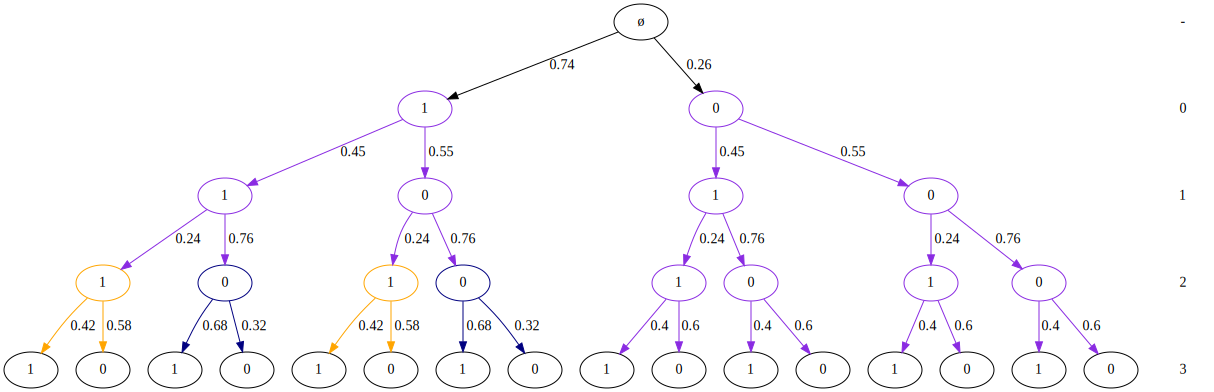

In [5]:
t.plot()

In [6]:
agraphs= t.to_minimal_context_agraphs()

None


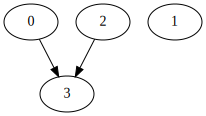

In [7]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]

X0=0


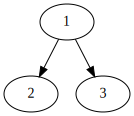

In [8]:
print(keys[1])
agraphs[keys[1]]

In [635]:
for g in agraphs:
    g.layout("dot")

dict

In [95]:
x2 = t.sample(5000)

In [96]:
x2

,0,1,2,3,4,5,6,7,8,9
0,2,2,2,2,2,2,2,2,2,2
1,1,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,0,1,0
4,1,1,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
4996,1,1,1,1,1,0,1,1,0,0
4997,1,0,1,1,1,1,1,1,1,1
4998,1,0,0,0,1,1,1,0,0,0
4999,0,1,1,0,1,1,0,0,1,0


In [118]:
ctl.n_stagings([2,2,2,2,2,2], 4, max_cvars=2)

65

In [120]:
score_table = sc.order_score_tables(x2, max_cvars=2, alpha_tot=1.0, method="BDeu")

#Stagings tables: 100%|██████████| 10/10 [00:00<00:00, 56.71it/s]


log_n_stagings: {'None': 0.0, '2': 0.0, '2,2': 0.6931471805599453, '2,2,2': 2.0794415416798357, '2,2,2,2': 3.332204510175204, '2,2,2,2,2': 4.174387269895637, '2,2,2,2,2,2': 4.836281906951478, '2,2,2,2,2,2,2': 5.37989735354046, '2,2,2,2,2,2,2,2': 5.840641657373398, '2,2,2,2,2,2,2,2,2': 6.240275845170769}


Order score tables: 100%|██████████| 10/10 [01:19<00:00,  8.00s/it]


In [121]:
orders2, scores2 = ctl.gibbs_order_sampler(2000, score_table)

initial order: [5, 8, 3, 4, 7, 1, 6, 9, 2, 0]
initial score: -29781.188535862224


Gibbs order sampler:   0%|          | 0/2000 [00:00<?, ?it/s]

Gibbs order sampler: 100%|██████████| 2000/2000 [00:01<00:00, 1478.07it/s]


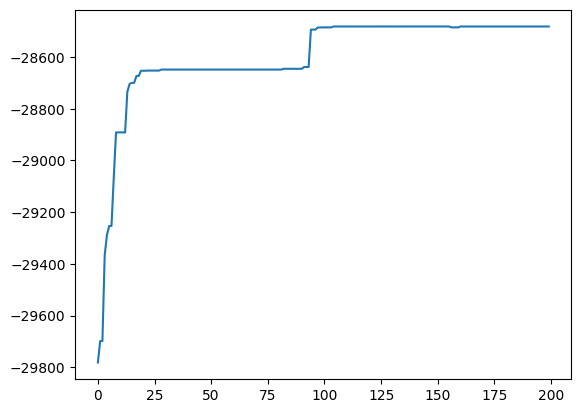

In [134]:
plt.plot(scores2[:200])

In [124]:
# Get the individual var locations on the order
var_positions = {var: [x.index(var) for x in orders2] for var in orders2[0]}
var_positions["iteration"] = list(range(len(orders2))) 
plotdf = pd.DataFrame(var_positions)

<AxesSubplot: xlabel='iteration'>

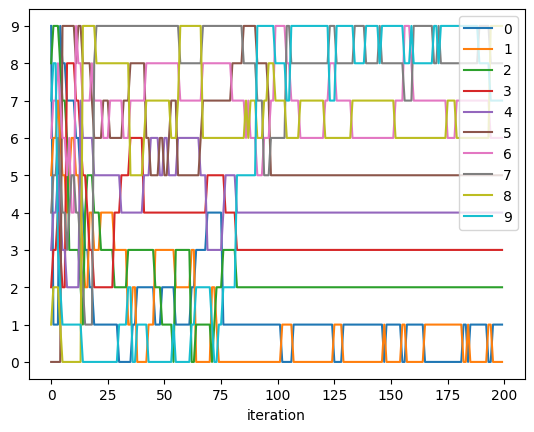

In [137]:
plotdf[:200].plot(x = "iteration", y = range(p), yticks=range(len(orders2[0])))

In [128]:
max(scores2)

-28481.91397601508

In [129]:
maxi = scores2.index(max(scores2))

In [130]:
orders2[maxi]

[0, 1, 2, 3, 4, 5, 8, 6, 7, 9]

In [523]:
s2 = sc.score_order(range(len(score_table)), x2, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")

score at level 0 : -3370.339615239277
score at level 1 : -3336.7562984763604
score at level 2 : -3396.2725918635624
score at level 3 : -1333.7035970800987
score at level 4 : -3412.105181799819


In [515]:
s2

-14849.177284459118

In [486]:
orders2

[[1, 0, 6, 2, 3, 9, 5, 8, 7, 4],
 [1, 0, 6, 2, 8, 3, 9, 5, 7, 4],
 [1, 0, 6, 2, 8, 3, 9, 5, 7, 4],
 [1, 0, 6, 2, 3, 9, 5, 7, 4, 8],
 [1, 4, 0, 6, 2, 3, 9, 5, 7, 8],
 [1, 4, 0, 6, 2, 3, 8, 9, 5, 7],
 [1, 4, 0, 6, 2, 3, 8, 9, 5, 7],
 [1, 0, 6, 2, 3, 4, 8, 9, 5, 7],
 [1, 0, 6, 2, 8, 3, 4, 9, 5, 7],
 [1, 0, 6, 2, 8, 3, 4, 9, 5, 7],
 [1, 0, 6, 2, 8, 3, 4, 9, 5, 7],
 [1, 0, 6, 2, 8, 3, 4, 7, 9, 5],
 [1, 0, 6, 2, 8, 3, 4, 9, 7, 5],
 [1, 0, 6, 2, 8, 7, 3, 4, 9, 5],
 [1, 0, 6, 2, 8, 7, 3, 4, 9, 5],
 [1, 0, 6, 2, 8, 7, 3, 4, 9, 5],
 [1, 0, 6, 2, 5, 8, 7, 3, 4, 9],
 [1, 0, 6, 5, 2, 8, 7, 3, 4, 9],
 [1, 0, 6, 2, 8, 7, 3, 4, 5, 9],
 [1, 0, 6, 2, 8, 7, 4, 5, 3, 9],
 [1, 0, 6, 8, 2, 7, 4, 5, 3, 9],
 [1, 0, 6, 2, 8, 7, 4, 5, 3, 9],
 [0, 1, 6, 2, 8, 7, 4, 5, 3, 9],
 [0, 1, 5, 6, 2, 8, 7, 4, 3, 9],
 [1, 0, 5, 6, 2, 8, 7, 4, 3, 9],
 [1, 0, 5, 4, 6, 2, 8, 7, 3, 9],
 [1, 0, 4, 6, 2, 8, 7, 3, 5, 9],
 [1, 0, 4, 6, 2, 8, 9, 7, 3, 5],
 [0, 4, 1, 6, 2, 8, 9, 7, 3, 5],
 [0, 4, 1, 6, 2, 8, 9, 7, 3, 5],
 [0, 4, 1,